Подключаем необходимые библиотеки

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


F:\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Читаем данные

In [32]:
zp = pd.read_csv('WAG_C_M.csv',';', parse_dates=['month'], dayfirst=True, index_col=['month'])

In [36]:
zp.describe()

,WAG_C_M
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


    Визуальный анализ ряда - смотрим график

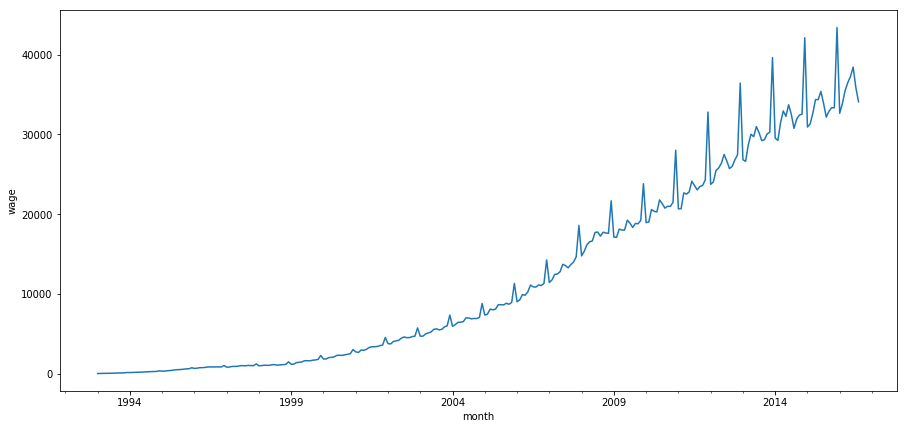

In [34]:
plt.figure(figsize(15,7))
zp.WAG_C_M.plot()
plt.ylabel('wage')
pylab.show()

До 1999 года видно плохо, но с 1999 явно видно восходящий тренд, и сезонность длиной 12 месяцев. Цикличности не видно.
Кроме того, дисперсия с ростом времени начинает прыгать.
Стационарность методом Дики-Фуллера можно не проверять, и так всё ясно - восходящий тренд ее исключает.
Но для тренировки проверим формально.

In [38]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zp.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.991850


Гипотеза о стационарности отвергается.

### Стабилизация дисперсии

Преобразование Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


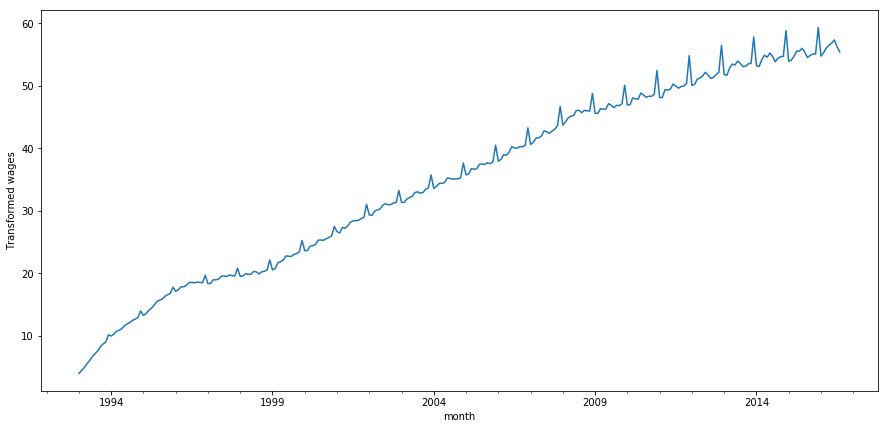

In [41]:
zp['wage_stabilized'], lmbda = stats.boxcox(zp.WAG_C_M)
plt.figure(figsize(15,7))
zp.wage_stabilized.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zp.wage_stabilized)[1])

С дисперсией стало лучше, но стационарность все равно не достигнута.
Ещё раз запустим преобразованием Бокса-Кокса:

In [ ]:
zp['wage_stabilized_2'], lmbda2 = stats.boxcox(zp.wage_stabilized)
plt.figure(figsize(15,7))
zp.wage_stabilized_2.plot()
plt.ylabel(u'Transformed wages (twice)')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda2)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zp.wage_stabilized_2)[1])

Не сдаёмся:

Оптимальный параметр преобразования Бокса-Кокса: 0.983604
Критерий Дики-Фуллера: p=0.595227


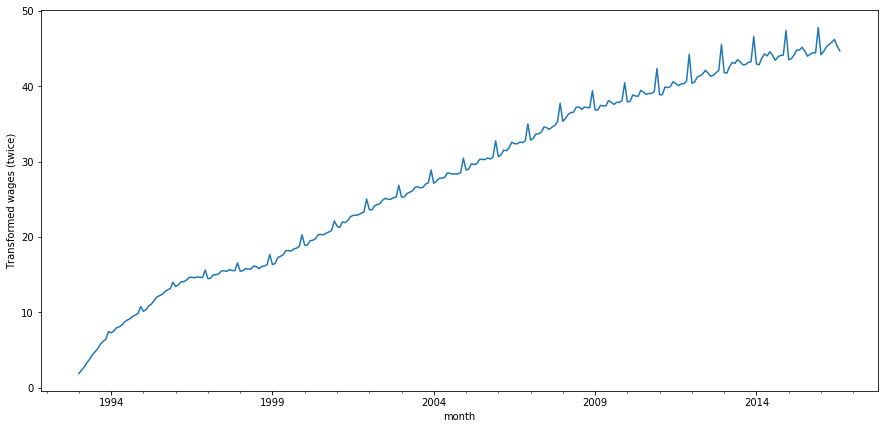

In [43]:
zp['wage_stabilized_3'], lmbda3 = stats.boxcox(zp.wage_stabilized_2)
plt.figure(figsize(15,7))
zp.wage_stabilized_3.plot()
plt.ylabel(u'Transformed wages (twice)')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda3)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zp.wage_stabilized_3)[1])

### Стационарность

Преобразование Бокса-Кокса перестало значимо помогать в достижении стационарности уже со второго шага. Поэтому применим дифференцирование к zp['wage_stabilized'].
Сначала сезонное:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

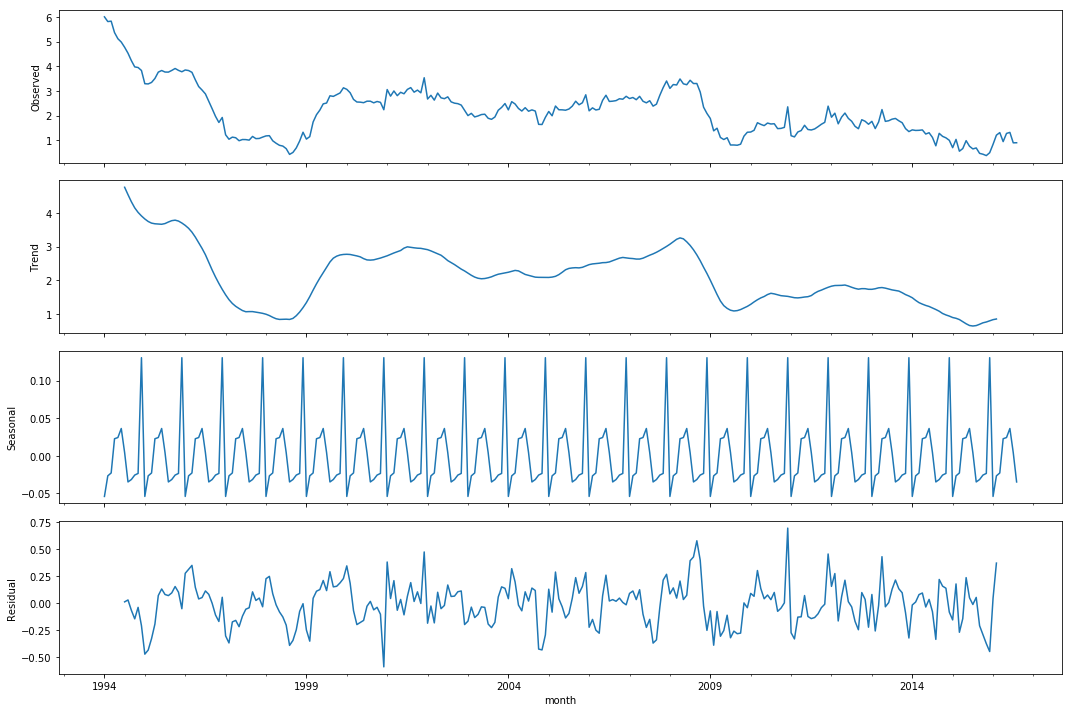

In [46]:
zp['wage_shifted'] = zp.wage_stabilized - zp.wage_stabilized.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(zp.wage_shifted[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zp.wage_shifted[12:])[1])

 Временной ряд стал больше похож на стационарный (но все равно выглядит подозрительно). Критерий Дики-Фуллера отвергает гипотезу о нестационарности. Всё же попробуем ещй раз продифференцировать, на этот раз обычным дифференцированием.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

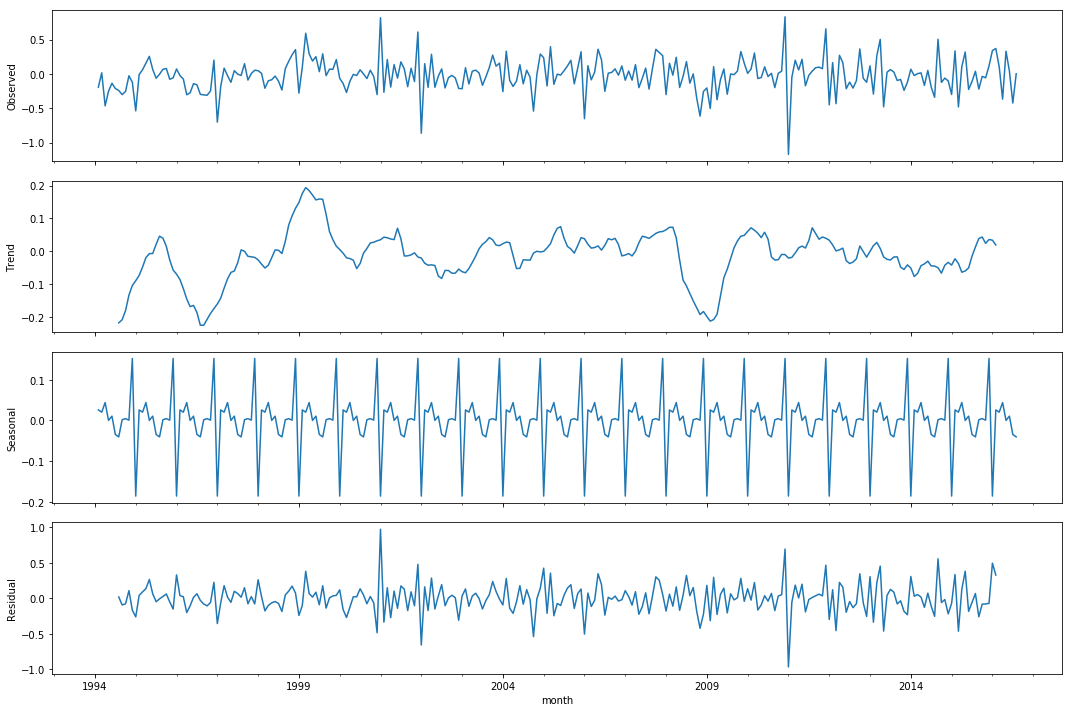

In [48]:
zp['wage_shifted2'] = zp.wage_shifted - zp.wage_shifted.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(zp.wage_shifted2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zp.wage_shifted2[13:])[1])

Гипотеза о нестационарности снова отвергается, но выглядит ряд всё равно подозрительно. Ещё раз продифференцируем:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

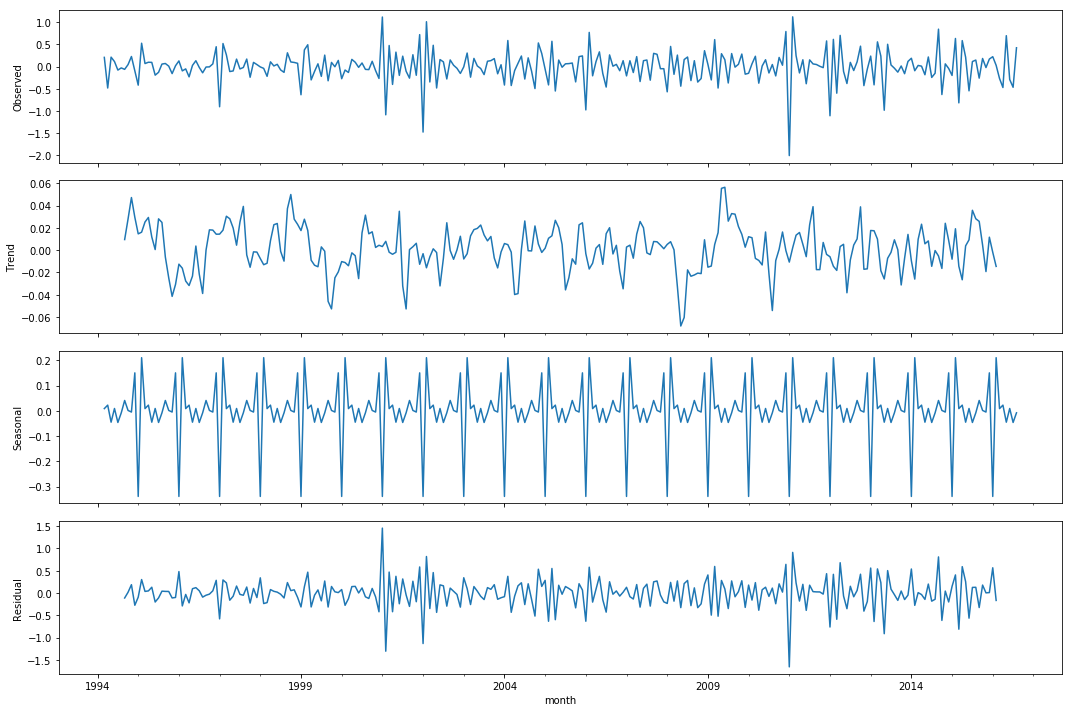

In [50]:
zp['wage_shifted3'] = zp.wage_shifted2 - zp.wage_shifted2.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(zp.wage_shifted3[14:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(zp.wage_shifted3[14:])[1])

Нестационарность снова отвергается. Ряд выглядит уже стационарным. Пожалуй, на этом остановимся :)
В итоге получили D=1, d=2

## Выбор начальных приближений для p, q, P, Q

Смотрим на графики автокорреляции и частичной автокорреляции:

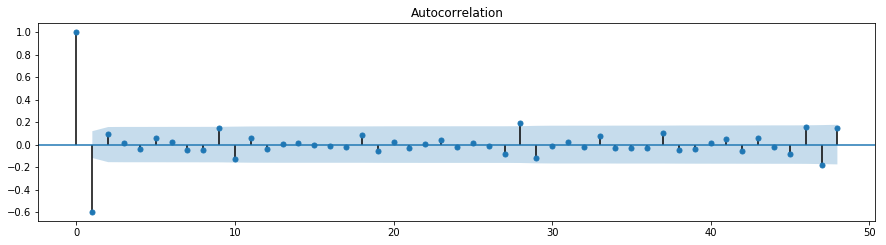

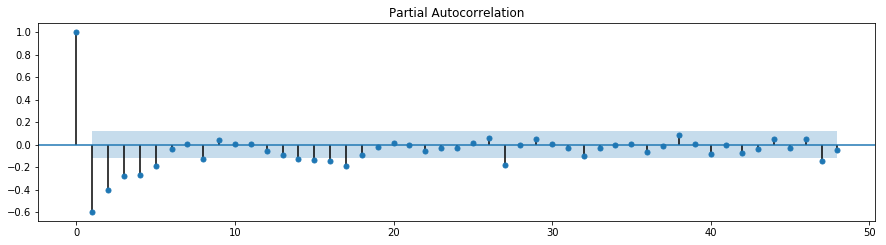

In [51]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(zp.wage_shifted3[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(zp.wage_shifted3[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()

получаем начальные приближения для q, Q, p, Q:

In [53]:
Q = 4
q = 1
P = 4
p = 5

аналогично примеру в курсе, назначаем диапазоны проверки:

In [57]:
ps = range(0, p+1)
d=2
qs = range(0, q+1)
Ps = range(0, P+1)
D=1
Qs = range(0, Q+1)

## Обучение  сравнение моделей

In [60]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

300

In [61]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(zp.wage_stabilized, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
        print('current params:', param)    
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('current params:', (0, 0, 0, 1))
('current params:', (0, 0, 0, 2))
('current params:', (0, 0, 0, 3))
('current params:', (0, 0, 0, 4))
('current params:', (0, 0, 1, 0))
('current params:', (0, 0, 1, 1))
('current params:', (0, 0, 1, 2))
('current params:', (0, 0, 1, 3))
('current params:', (0, 0, 1, 4))
('current params:', (0, 0, 2, 0))
('current params:', (0, 0, 2, 1))
('current params:', (0, 0, 2, 2))
('current params:', (0, 0, 2, 3))
('current params:', (0, 0, 2, 4))
('current params:', (0, 0, 3, 0))
('current params:', (0, 0, 3, 1))
('current params:', (0, 0, 3, 2))
('current params:', (0, 0, 3, 3))
('current params:', (0, 0, 3, 4))
('current params:', (0, 0, 4, 0))
('current params:', (0, 0, 4, 1))
('current params:', (0, 0, 4, 2))
('current params:', (0, 0, 4, 3))
('current params:', (0, 0, 4, 4))
('current params:', (0, 1, 0, 0))
('current params:', (0, 1, 0, 1))
('current params:', (0, 1, 0, 2))
('current params:', (0, 1, 0, 3))
('current pa

 Долго :)

In [62]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
295  (5, 1, 4, 1) -7.472607
145  (2, 1, 4, 1) -6.188941
88   (1, 1, 2, 4) -4.462451
195  (3, 1, 4, 1) -4.284815
138  (2, 1, 2, 4) -4.267811


Лучшая модель из найденных:

In [63]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    wage_stabilized   No. Observations:                  284
Model:             SARIMAX(5, 2, 1)x(4, 1, 1, 12)   Log Likelihood                  15.736
Date:                            Tue, 02 Apr 2019   AIC                             -7.473
Time:                                    20:00:41   BIC                             36.315
Sample:                                01-01-1993   HQIC                            10.083
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1662      0.054     -3.082      0.002      -0.272      -0.061
ar.L2         -0.0090      0.039   

### Анализ остатков

Критерий Стьюдента: p=0.897825
Критерий Дики-Фуллера: p=0.000000


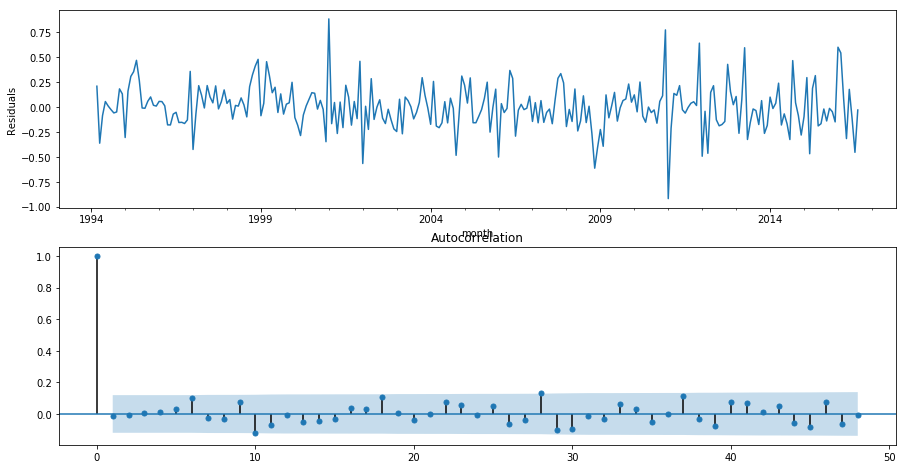

In [65]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[14:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[14:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[14:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[14:])[1])

Остатки несмещены и стационарны, подтверждается соответствующими критериями.

Как и в примере курса, проверим, насколько хорошо модель описывает данные.

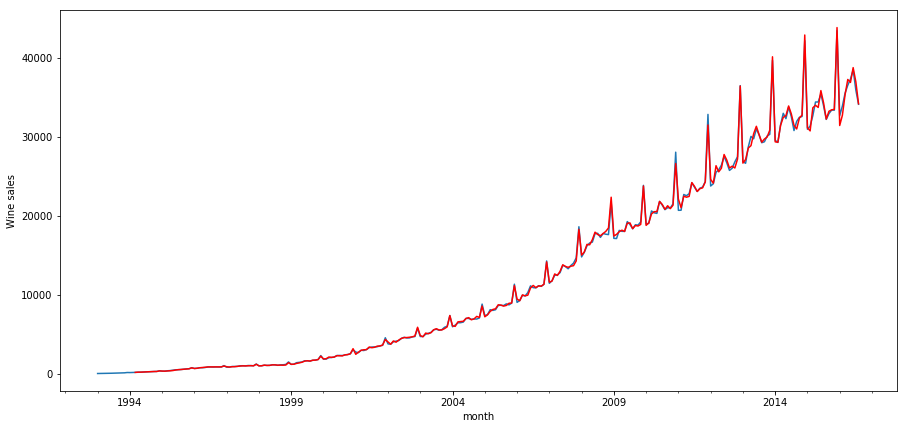

In [66]:
zp['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
zp.WAG_C_M.plot()
zp.model[14:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Получилось похоже.

### Прогноз

In [71]:
zp.shape

(284, 8)

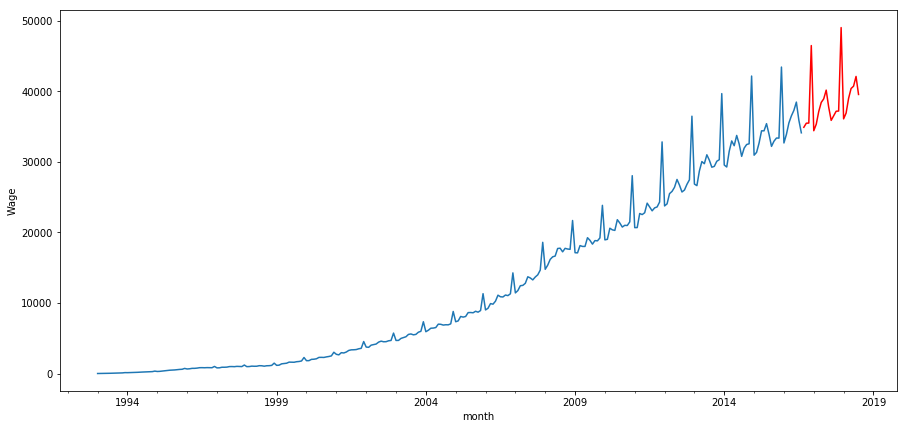

In [80]:
zp2 = zp[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= zp2.columns)
zp2 = pd.concat([zp2, future])
zp2['forecast'] = invboxcox(best_model.predict(start=284, end=311), lmbda)

plt.figure(figsize(15,7))
zp.WAG_C_M.plot()
zp2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()